In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import gplately
import pandas as pd

%matplotlib inline

reconstruction_times = np.arange(0,171)

agegrid_dir = "/Users/ben/Dropbox/USyd/GPlates/"
agegrid_filename = agegrid_dir+"slab_dip/Clennet_AgeGrids_0.1d_masked/seafloor_age_mask_{:.1f}Ma.nc"

In [2]:
# Call GPlately's DataServer from the download.py module
gdownload = gplately.download.DataServer("Clennett2020")

# Obtain all rotation files, topology features and static polygons from Muller et al. 2019
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

Checking whether the requested files need to be updated...
Requested files are up-to-date!


In [3]:
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

# Obtain geometry shapefiles with gdownload
coastlines, continents, COBs = gdownload.get_topology_geometries()

# Call the PlotTopologies object
time = 0 #Ma
gplot = gplately.plot.PlotTopologies(model, coastlines, continents, COBs, time=time)

Checking whether the requested files need to be updated...
Requested files are up-to-date!


In [4]:
subfz_raster = gplately.Raster(filename="subducted_fz_ages.nc")


In [5]:
metal_dict = dict()

commodities = ['Cu (Mt)', 'Pb (Mt)', 'Zn (Mt)', 'Ni (Mt)']
sheets = ['PbZn-CD', 'PbZn-MVT', 'Cu-sed', 'Magmatic Ni', 'VMS', 'Cu-por', 'IOCG']

for sheet in sheets:
    df = pd.read_excel('data/base_metal_deposit_compilation.xls', sheet_name=sheet, na_values='ND')
    df = df[df['Age (Ga)'].notna()]
    df = df[df['Age (Ga)']*1000 <= reconstruction_times.max()]

    if df.shape[0] > 0:
        metal_dict[sheet] = df
    else:
        sheets.remove(sheet)
        
symbols = ['o', 'v', 's', '*', 'd', '^', 'P']*2

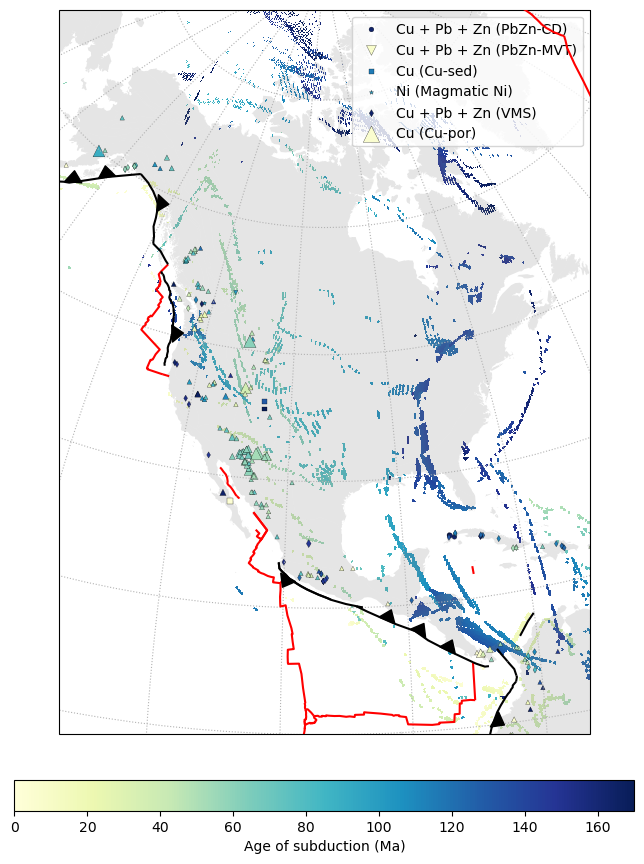

In [6]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12), dpi=100)
ax = fig.add_subplot(111, projection=ccrs.AzimuthalEquidistant(-100, 30))
ax.set_extent([-130, -70, 0, 85])
ax.gridlines(color='0.7',linestyle=':', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))


# Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
gplot.time = 0 # Ma
# gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.05)
im = gplot.plot_grid(ax, subfz_raster.data, origin='lower', cmap='YlGnBu', interpolation='None', vmin=0)
gplot.plot_coastlines(ax, color='0.5', alpha=0.2)
gplot.plot_ridges_and_transforms(ax, color='red', zorder=9)

gplot.plot_trenches(ax, color='k', zorder=9, )
gplot.plot_subduction_teeth(ax, color='k', zorder=10, )


for i, sheet in enumerate(sheets):
    df = metal_dict[sheet]
    
    # create label for each sheet and add commodities
    label = ""
    size  = np.zeros(df.shape[0])
    for commodity in commodities:
        if commodity in df:
            label += "{} + ".format(commodity[:-5])
            size  += df[commodity].fillna(0.0).to_numpy()
    label = label[:-3] + " ({})".format(sheet)
    
    sc = ax.scatter(df['Lon'], df['Lat'], s=10+size*2, c=df['Age (Ga)']*1000, marker=symbols[i], cmap='YlGnBu',
                    vmin=0, vmax=reconstruction_times.max(),
                    label=label, transform=ccrs.PlateCarree(), edgecolor='k', linewidth=0.2)

    
fig.colorbar(im, shrink=0.5, pad=0.05, orientation='horizontal', label='Age of subduction (Ma)')
ax.legend()

Create a `gplately.Points` object for all deposits

In [7]:
pts_dict = dict()

for i, sheet in enumerate(sheets):
    df = metal_dict[sheet]

    pts_dict[sheet] = gplately.Points(model, df['Lon'], df['Lat'])

We want to reconstruct these deposits with an age uncertainty buffer that can be user-defined

In [8]:
from scipy.spatial import cKDTree
def KD_dist(lons0, lats0, lons1, lats1):
    x0, y0, z0 = gplately.tools.lonlat2xyz(lons0, lats0)
    x1, y1, z1 = gplately.tools.lonlat2xyz(lons1, lats1)
    
    tree = cKDTree(np.c_[x0, y0, z0])
    d, idx = tree.query(np.c_[x1, y1, z1])
    return d*gplately.EARTH_RADIUS, idx

In [9]:
for i, sheet in enumerate(sheets):
    gpts = pts_dict[sheet]
    df = metal_dict[sheet]
    
    print(df.shape)

(3, 16)
(18, 15)
(19, 8)
(1, 12)
(162, 8)
(428, 6)


Calculate distance between deposit and fracture zone

In [12]:
age_buffer = 10 # Ma

for i, sheet in enumerate(sheets):
    gpts = pts_dict[sheet]
    df = metal_dict[sheet]
    
    distances    = np.zeros((df.shape[0], age_buffer))
    fz_magnitude = np.zeros((df.shape[0], age_buffer))
    
    for a in range(0, age_buffer):
        ages = np.clip(df['Age (Ga)']*1000 - a, 0, reconstruction_times.max()).astype(int)
        rlons, rlats = gpts.reconstruct_to_birth_age(ages)
        
        with np.load("subducted_fz_data.npz", "r") as npz:
            for i, age in enumerate(ages):
                # extract lon, lat, mag fracture zone data for a given age
                fz_data = npz[str(int(age))]
                fz_lons, fz_lats, fz_mag = fz_data

                # find distance between a reconstructed deposit and fracture zones
                dist = gplately.tools.haversine_distance(rlons[i], fz_lons,
                                                         rlats[i], fz_lats,
                                                         degrees=True)

                # find the minimum distance
                idx_dist = dist.argmin()
                distances[i,a]    = dist[idx_dist]*1e-3
                fz_magnitude[i,a] = fz_mag[idx_dist]
    
    idx_distances = distances.argmin(axis=1)
    
    rows = range(0, df.shape[0])
    df = df.assign(distance_to_deposit=distances[rows,idx_distances])
    df = df.assign(fz_magnitude=fz_magnitude[rows,idx_distances])
    metal_dict[sheet] = df

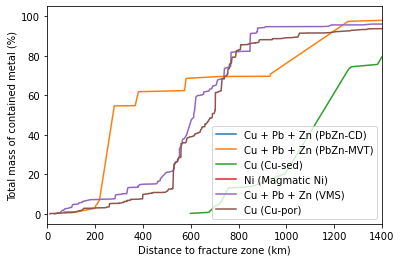

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(111, xlim=[0,1400])
ax1.set_xlabel('Distance to fracture zone (km)')
ax1.set_ylabel('Total mass of contained metal (%)')

for sheet in sheets:
    df = metal_dict[sheet]
    
    # create label for each sheet and add commodities
    label = ""
    size  = np.zeros(df.shape[0])
    for commodity in commodities:
        if commodity in df:
            label += "{} + ".format(commodity[:-5])
            size  += df[commodity].fillna(0.0).to_numpy()
    label = label[:-3] + " ({})".format(sheet)
    
    dist = df['distance_to_deposit'].to_numpy()

    # create cumulative distribution
    idx_sort = dist.argsort()
    dist = dist[idx_sort]
    size = size[idx_sort]
    size /= size.sum()
    cumsum_size = np.cumsum(size)
    
    ax1.plot(dist, cumsum_size*100, label=label)

ax1.legend()

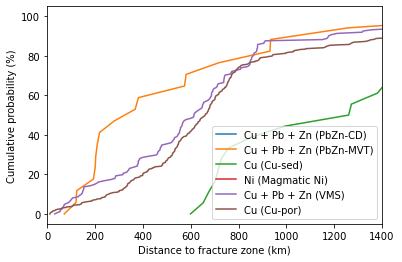

In [14]:
fig = plt.figure()
ax1 = fig.add_subplot(111, xlim=[0,1400])
ax1.set_xlabel('Distance to fracture zone (km)')
ax1.set_ylabel('Cumulative probability (%)')

for sheet in sheets:
    df = metal_dict[sheet]
    
    # create label for each sheet and add commodities
    label = ""
    size  = np.zeros(df.shape[0])
    for commodity in commodities:
        if commodity in df:
            label += "{} + ".format(commodity[:-5])
            size  += df[commodity].fillna(0.0).to_numpy()
    label = label[:-3] + " ({})".format(sheet)
    
    dist = df['distance_to_deposit'].to_numpy()

    # create cumulative distribution
    idx_sort = dist.argsort()
    dist = dist[idx_sort]

    cumsum_size = np.linspace(0,1,dist.size)
    
    ax1.plot(dist, cumsum_size*100, label=label)

ax1.legend()

Check for any correlation with the "magnitude" of the fracture zone.

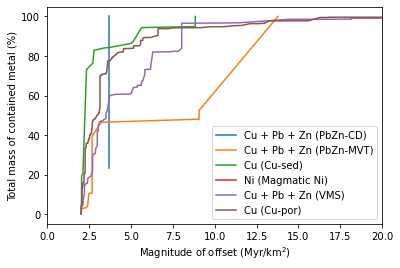

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(111, xlim=[0,20])
ax1.set_xlabel('Magnitude of offset (Myr/km$^2$)')
ax1.set_ylabel('Total mass of contained metal (%)')

for sheet in sheets:
    df = metal_dict[sheet]
    
    # create label for each sheet and add commodities
    label = ""
    size  = np.zeros(df.shape[0])
    for commodity in commodities:
        if commodity in df:
            label += "{} + ".format(commodity[:-5])
            size  += df[commodity].fillna(0.0).to_numpy()
    label = label[:-3] + " ({})".format(sheet)
    
    mag = df['fz_magnitude'].to_numpy(copy=True)

    # create cumulative distribution
    idx_sort = mag.argsort()
    mag = mag[idx_sort]
    size = size[idx_sort]
    size /= size.sum()
    cumsum_size = np.cumsum(size)
    
    ax1.plot(mag, cumsum_size*100, label=label)

ax1.legend()

Now identify the distance between deposits and random intersections of subduction zones with fracture zones

In [16]:
def segmentise_boundaries(subduction_lon, subduction_lat, tessellation_threshold_radians=np.deg2rad(0.2)):
    
    earth_radius = 6371.0

    dtol = tessellation_threshold_radians*earth_radius + 5.0 # km
    segment_IDs = np.zeros(len(subduction_lon), dtype=int)

    index = 1
    for i in range(0, len(subduction_lon)-1):
        lon0 = subduction_lon[i]
        lat0 = subduction_lat[i]
        lon1 = subduction_lon[i+1]
        lat1 = subduction_lat[i+1]

        # distance between points (convert to unit sphere)
        
        xs, ys, zs = gplately.tools.lonlat2xyz([lon0,lon1], [lat0,lat1])
        dist = np.sqrt((xs[1]-xs[0])**2 + (ys[1]-ys[0])**2 + (zs[1]-zs[0])**2) * earth_radius

        if dist < dtol:
            # add to current segment
            segment_IDs[i] = index

        elif np.count_nonzero(segment_IDs == index) > 1:
            segment_IDs[i] = index
            index += 1
        else:
            pass

    unique_segment_IDs = set(segment_IDs)
    unique_segment_IDs.remove(0)
    return segment_IDs, unique_segment_IDs

In [27]:
tessellation_radians = np.deg2rad(0.2)

def random_fracture_zones(lon, lat, age, niter=10):
    subduction_data = model.tessellate_subduction_zones(int(age), tessellation_radians, ignore_warnings=True)
    trench_lons = subduction_data[:,0]
    trench_lats = subduction_data[:,1]
    
    # load fz data
    with np.load("subducted_fz_data.npz", "r") as npz:
        fz_data = npz[str(int(age))]
        fz_lons, fz_lats, fz_mag = fz_data
    
#     # find trench boundaries
#     trench_segments, unique_trench_segments = segmentise_boundaries(trench_lons, trench_lats, tessellation_radians)
    
#     # put trenches in K-D tree
#     tree_trenches = cKDTree(np.c_[trench_lons, trench_lats])
#     trench_dist, index = tree_trenches.query(np.c_[fz_lons, fz_lats])
    
#     # identify which trench segment the fz belongs to
#     fz_segments = trench_segments[index]
    
#     unique_fz_segments, n_intersections = np.unique(fz_segments, return_counts=True)
    
#     print(fz_segments.shape, trench_dist.shape, trench_lons.shape, fz_lons.shape)
#     print(fz_segments)
#     print(unique_fz_segments, n_intersections)
    
#     permuted_trench_lons = np.empty(trench_lons.size)
#     permuted_trench_lats = np.empty(trench_lats.size)
    
    
    min_dist = 1e12
    
    # find some random arbitrary permutation (keeping the same number of fz intersections)
    for i in range(0, niter):
        idx = np.random.permutation(len(fz_lons))

        dist = gplately.tools.haversine_distance(lon, trench_lons[idx],
                                                 lat, trench_lats[idx],
                                                 degrees=True)
        
        min_dist = min(min_dist, dist.min()*1e-3)
    
    return min_dist

In [28]:
from joblib import Parallel, delayed

In [20]:
for sheet in sheets:
    df = metal_dict[sheet]

    # Use LokyBackend to protect the netCDF routine
    sz_data = Parallel(n_jobs=-3, backend='loky', verbose=1)\
    (delayed(random_fracture_zones) (*data) for data in zip(df['Lon'], df['Lat'], df['Age (Ga)']*1000))
    
    df = df.assign(distance_to_trench=np.array(sz_data))
    metal_dict[sheet] = df

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done   3 out of   3 | elapsed:    5.4s finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  18 out of  18 | elapsed:   13.8s finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  19 out of  19 | elapsed:   13.5s finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 out of   1 | elapsed:    4.0s finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
/Users/ben/miniforge3/envs/mapping/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   23.0s
[Pa

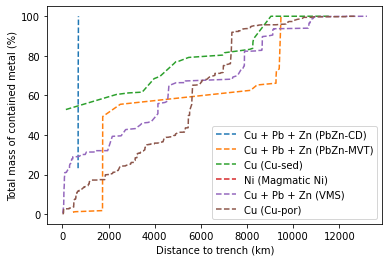

In [21]:
fig = plt.figure()
ax1 = fig.add_subplot(111, )
ax1.set_xlabel('Distance to trench (km)')
ax1.set_ylabel('Total mass of contained metal (%)')


for sheet in sheets:
    df = metal_dict[sheet]
    
    # create label for each sheet and add commodities
    label = ""
    size  = np.zeros(df.shape[0])
    for commodity in commodities:
        if commodity in df:
            label += "{} + ".format(commodity[:-5])
            size  += df[commodity].fillna(0.0).to_numpy()
    label = label[:-3] + " ({})".format(sheet)
    
    # cumulative distribution of subduction zone background
    dist = df['distance_to_trench'].to_numpy()
    idx_sort = dist.argsort()
    dist = dist[idx_sort]
    size = size[idx_sort]
    size /= size.sum()
    cumsum_size = np.cumsum(size)
    
    ax1.plot(dist, cumsum_size*100, label=label, linestyle='--')
    
ax1.legend()

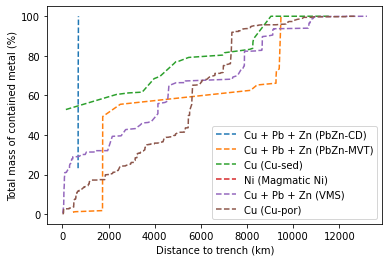

In [22]:
fig = plt.figure()
ax1 = fig.add_subplot(111, )
ax1.set_xlabel('Distance to trench (km)')
ax1.set_ylabel('Total mass of contained metal (%)')


for sheet in sheets:
    df = metal_dict[sheet]
    
    # create label for each sheet and add commodities
    label = ""
    size  = np.zeros(df.shape[0])
    for commodity in commodities:
        if commodity in df:
            label += "{} + ".format(commodity[:-5])
            size  += df[commodity].fillna(0.0).to_numpy()
    label = label[:-3] + " ({})".format(sheet)
    
    # cumulative distribution of subduction zone background
    dist = df['distance_to_trench'].to_numpy()
    idx_sort = dist.argsort()
    dist = dist[idx_sort]
    size = size[idx_sort]
    size /= size.sum()
    cumsum_size = np.cumsum(size)
    
    ax1.plot(dist, cumsum_size*100, label=label, linestyle='--')
    
ax1.legend()

In [23]:
from scipy import ndimage

def cdf_distance(dist, size):
    idx_sort = dist.argsort()
    dist = dist[idx_sort].copy()
    size = size[idx_sort].copy()
    size /= size.sum()
    cumsum_size = np.cumsum(size)
    return dist, cumsum_size

def smooth_1D(array, sigma=3, axis=-1):
    return ndimage.gaussian_filter1d(array, sigma, axis=axis)

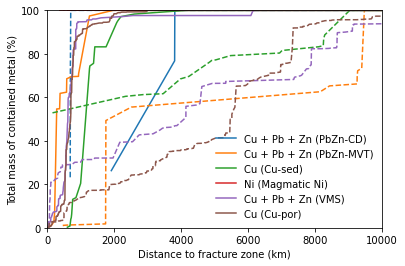

In [24]:
fig = plt.figure()
ax1 = fig.add_subplot(111, xlim=[0,10000], ylim=[0,100])
ax1.set_xlabel('Distance to fracture zone (km)')
ax1.set_ylabel('Total mass of contained metal (%)')


for i, sheet in enumerate(sheets):
    df = metal_dict[sheet]
    
    # create label for each sheet and add commodities
    label = ""
    size  = np.zeros(df.shape[0])
    for commodity in commodities:
        if commodity in df:
            label += "{} + ".format(commodity[:-5])
            size  += df[commodity].fillna(0.0).to_numpy()
    label = label[:-3] + " ({})".format(sheet)
    
    dist = df['distance_to_deposit'].to_numpy(copy=True)
    dist_to_deposit, cumsize_deposit = cdf_distance(dist, size)
    
    # cumulative distribution of subduction zone background
    dist = df['distance_to_trench'].to_numpy(copy=True)
    dist_to_trench, cumsize_trench = cdf_distance(dist, size)

    # stretch out to the maximum distance range
    dmin, dmax = ax1.get_xlim()
    dist_to_deposit = np.hstack([dist_to_deposit, [dmax]])
    cumsize_deposit = np.hstack([cumsize_deposit, [1]])
    dist_to_trench  = np.hstack([dist_to_trench,  [dmax]])
    cumsize_trench  = np.hstack([cumsize_trench,  [1]])
    
    
    ax1.plot(dist_to_deposit, cumsize_deposit*100, c='C{}'.format(i), label=label)
    ax1.plot(dist_to_trench,  cumsize_trench*100,  c='C{}'.format(i), linestyle='--')
    
ax1.legend(frameon=False)
fig.savefig("fz_deposit_cdf.pdf", bbox_inches='tight', dpi=300)

Save dataframes to file

In [26]:
with pd.ExcelWriter("data/base_metal_deposit_compilation_processed.xlsx") as writer:
    for sheet in sheets:
        df = metal_dict[sheet]
        df.to_excel(writer, sheet_name=sheet)